In [36]:
#https://analyticsindiamag.com/semantic-segmentation-using-tensorflow-keras/

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
from scipy import io
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import glob
import os 

In [38]:
#Resizing images, if needed
SIZE_X = 256
SIZE_Y = 256
n_classes=23 #Number of classes for segmentation
gpu_available = tf.config.list_physical_devices('GPU')
print(gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [39]:
images = []

for directory_path in glob.glob("drone_dataset/images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(tf.convert_to_tensor(img))

print(len(images))

400


In [40]:
masks = []

for directory_path in glob.glob("drone_dataset/masks/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        masks.append(tf.convert_to_tensor(mask))

print(len(masks))

400


In [41]:
print(type(images))
print(type(masks))
print(mask[0].shape)

<class 'list'>
<class 'list'>
(256,)


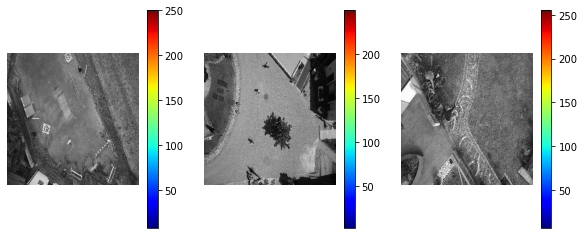

In [42]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = images[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show() 

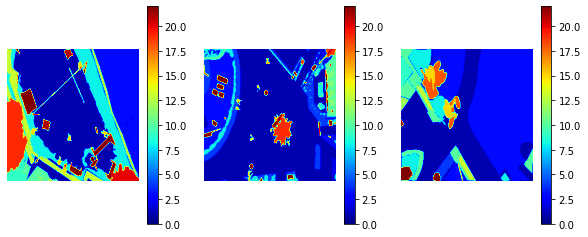

In [43]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = masks[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show()

In [44]:
#number of classes
num_classes = masks[0].numpy().max()
num_classes

22

In [45]:
#Build Downstack Model
base = keras.applications.DenseNet121(input_shape=[SIZE_X, SIZE_Y, 3], include_top=False, weights='imagenet')
#base.summary()

In [46]:
skip_names = ['conv1/relu', # size 64*64
              'pool2_relu',  # size 32*32
              'pool3_relu',  # size 16*16
              'pool4_relu',  # size 8*8
              'relu'        # size 4*4
              ] 

In [47]:
skip_outputs = [base.get_layer(name).output for name in skip_names]
for i in range(len(skip_outputs)):
    print(skip_outputs[i]) 

KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 64), dtype=tf.float32, name=None), name='conv1/relu/Relu:0', description="created by layer 'conv1/relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 256), dtype=tf.float32, name=None), name='pool2_relu/Relu:0', description="created by layer 'pool2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 512), dtype=tf.float32, name=None), name='pool3_relu/Relu:0', description="created by layer 'pool3_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 1024), dtype=tf.float32, name=None), name='pool4_relu/Relu:0', description="created by layer 'pool4_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [48]:
downstack = keras.Model(inputs=base.input, outputs=skip_outputs)
downstack.trainable = False

In [49]:
#Build Upstack Model
from tensorflow_examples.models.pix2pix import pix2pix

In [50]:
upstack = [pix2pix.upsample(512,3),
           pix2pix.upsample(256,3),
           pix2pix.upsample(128,3),
           pix2pix.upsample(64,3)] 

In [51]:
upstack[0].layers

In [52]:
#Build a U-Net model by merging downstack and upstack with skip-connections.

# define the input layer
inputs = keras.layers.Input(shape=[SIZE_X, SIZE_Y, 3])
print(inputs)

# downsample
down = downstack(inputs)
out = down[-1]
print(out)

# prepare skip-connections
skips = reversed(down[:-1])

# choose the last layer at first 4 --> 8
# upsample with skip-connections

for up, skip in zip(upstack,skips):
    out = up(out)
    out = keras.layers.Concatenate()([out,skip])

out = keras.layers.Conv2DTranspose((num_classes+1), 3,
                                   strides=2,
                                   padding='same')(out)

print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1024), dtype=tf.float32, name=None), name='model_2/relu/Relu:0', description="created by layer 'model_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 23), dtype=tf.float32, name=None), name='conv2d_transpose_10/BiasAdd:0', description="created by layer 'conv2d_transpose_10'")


In [53]:
# complete unet model
unet = keras.Model(inputs=inputs, outputs=out)
#unet.summary()

In [54]:
def resize_image(image):
    image = tf.cast(image, tf.float32)
    # scale values to [0,1]
    image = image/255.0
    return image 

In [55]:
def resize_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.cast(mask, tf.uint8)
    return mask

In [56]:
X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]
print(y[0].shape)

(256, 256, 1)


In [57]:
from sklearn.model_selection import train_test_split
train_X, val_X,train_y, val_y = train_test_split(X,y, test_size=0.1, random_state=0)

In [58]:
print(len(train_X))
print(train_X[0].shape)
print(len(val_X))
print(len(train_y))
print(train_y[0].shape)
print(len(val_y))

360
(256, 256, 3)
40
360
(256, 256, 1)
40


In [59]:
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)
train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

In [60]:
train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

In [61]:
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))
print(val)

<ZipDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))>


In [62]:
#implimenting data augmentation
def brightness(img, mask):
     img = tf.image.adjust_brightness(img, 0.1)
     return img, mask
 
def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    img = tf.image.central_crop(img, 0.7)
    img = tf.image.resize(img, (SIZE_X,SIZE_Y))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (SIZE_X,SIZE_Y))
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

In [63]:
# perform augmentation on train data only
a = train.map(brightness)
#b = train.map(gamma)
#c = train.map(hue)
d = train.map(crop)
e = train.map(flip_hori)
f = train.map(flip_vert)
g = train.map(rotate)

train = train.concatenate(a)
#train = train.concatenate(b)
#train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g) 

In [64]:
#Prepare data batches. Shuffle the train data.

BATCH = 16
AT = tf.data.AUTOTUNE
BUFFER = 400 #num of images
STEPS_PER_EPOCH = len(train_X)//BATCH
VALIDATION_STEPS = len(val_X)//BATCH
train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

In [65]:
# example = next(iter(train))
# preds = unet(example[0])
# plt.imshow(example[0][60])
# plt.colorbar()
# plt.show() 

In [66]:
# pred_mask = tf.argmax(preds, axis=-1)
# pred_mask = tf.expand_dims(pred_mask, -1)
# plt.imshow(pred_mask[0])
# plt.colorbar() 

In [67]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001, verbose=1, patience=55),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=50, min_lr=1e-20, verbose=1, cooldown=5),
    tf.keras.callbacks.ModelCheckpoint(filepath="best_model_128.hdf5", monitor='val_accuracy', mode='max', save_best_only=True)
    ]

In [68]:
unet.compile(loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy']) 

In [69]:
hist = unet.fit(train,
            validation_data=val,
            verbose=1,
            steps_per_epoch=STEPS_PER_EPOCH,
            validation_steps=VALIDATION_STEPS,
            callbacks=my_callbacks,
            epochs=120)

Epoch 1/120
22/22 [==============================] - 20s 296ms/step - loss: 2.4405 - accuracy: 0.3610 - val_loss: 2.5111 - val_accuracy: 0.4220 - lr: 0.0010
Epoch 2/120
22/22 [==============================] - 5s 211ms/step - loss: 1.7258 - accuracy: 0.5386 - val_loss: 2.1572 - val_accuracy: 0.4955 - lr: 0.0010
Epoch 3/120
22/22 [==============================] - 5s 207ms/step - loss: 1.4761 - accuracy: 0.5903 - val_loss: 1.8728 - val_accuracy: 0.5412 - lr: 0.0010
Epoch 4/120
22/22 [==============================] - 4s 193ms/step - loss: 1.3690 - accuracy: 0.6131 - val_loss: 1.6996 - val_accuracy: 0.6012 - lr: 0.0010
Epoch 5/120
22/22 [==============================] - 4s 206ms/step - loss: 1.2877 - accuracy: 0.6285 - val_loss: 1.5598 - val_accuracy: 0.6244 - lr: 0.0010
Epoch 6/120
22/22 [==============================] - 4s 204ms/step - loss: 1.2447 - accuracy: 0.6332 - val_loss: 1.3870 - val_accuracy: 0.6297 - lr: 0.0010
Epoch 7/120
22/22 [==============================] - 5s 207ms/s

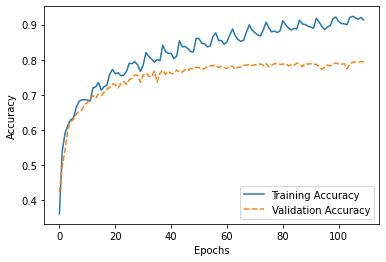

In [70]:
history = hist.history
acc=history['accuracy']
val_acc = history['val_accuracy']
plt.plot(acc, '-', label='Training Accuracy')
plt.plot(val_acc, '--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

LOAD AND EVALUATE THE MODEL

In [71]:
# loaded_model = keras.models.load_model("best_model_256.hdf5")
# #loaded_model.summary()

In [72]:
# new_model_test_loss, new_model_test_acc = loaded_model.evaluate(val)

# print('\nTest dataset')
# print(f"Loss: {new_model_test_loss}")
# print(f"Accuracy: {round((new_model_test_acc * 100), 2)} %")

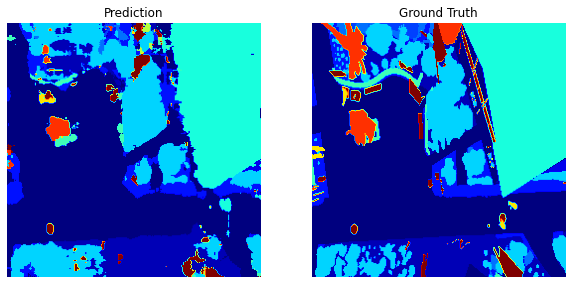

In [73]:
img, mask = next(iter(val))
pred = unet.predict(img)

plt.figure(figsize=(10,5))
for i in pred:
    plt.subplot(121)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet')
    plt.axis('off')
    plt.title('Prediction')
    break

plt.subplot(122)
plt.imshow(mask[0], cmap='jet')
plt.axis('off')
plt.title('Ground Truth')
plt.show()